In [1]:
import random
import numpy as np
from numpy.linalg import norm as vector_norm
import matplotlib.pyplot as plt
from itertools import product

import sys
sys.path.append('../modules')
from nsw.nsw_classifier import NSWClassifier
from nsw import rbf

In [2]:
from itertools import product

def plot_potential(mn, mx, f, eps, width=51):
    xi = yi = np.linspace(mn, mx, width)
    pairs = np.array(list(product(xi, yi)))
    test = f(pairs[0], eps)
    print(type(test))
    if type(test) == float or type(test) == np.float64 or type(test) == int:
        print('flat')
        zi = np.array([f(pair, eps) for pair in pairs]).reshape((width, -1))
        mnv, mxv = zi.min(), zi.max()
        mnv, mxv = -max(abs(mnv), abs(mxv)), max(abs(mnv), abs(mxv))
        fig, ax = plt.subplots(figsize=(15, 15))
        c = ax.pcolormesh(xi, yi, zi, cmap='RdBu', vmin=mnv, vmax=mxv)
        ax.set_title('class edge')
        # set the limits of the plot to the limits of the data
        ax.axis([xi.min(), xi.max(), yi.min(), yi.max()])
        fig.colorbar(c, ax=ax)
        plt.show()
    else:
        print('field')
        zi = np.array([f(pair, eps) for pair in pairs]).reshape((-1, 2))
        fig, ax = plt.subplots(figsize=(15, 15))
        c = ax.quiver(pairs[:, 0], pairs[:, 1], zi[:,0], zi[:, 1], width=.0008)
        ax.set_title('class edge')
        # set the limits of the plot to the limits of the data
        ax.axis([xi.min(), xi.max(), yi.min(), yi.max()])
        plt.show()

Classifier graph is build in 19.778s


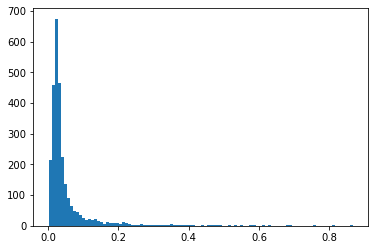

In [3]:
G = NSWClassifier()

N = 4000
values = []
for i in range(N):
    p = np.array([random.random(), random.random()])
    cls = 1 if vector_norm(p - np.array([.5, .5])) < 0.4 else 0
    if random.random() > .97: cls = 1 - cls
    values.append((p, cls))

G.build_navigable_graph(values, attempts=10)

rich_cut = sorted([(e, G.dist(G.nodes[e[0]].value, G.nodes[e[1]].value)) for e in G.cut], key=lambda v: v[1])
lengths = [e[1] for e in rich_cut]
plt.hist(lengths, bins=100)
plt.show()

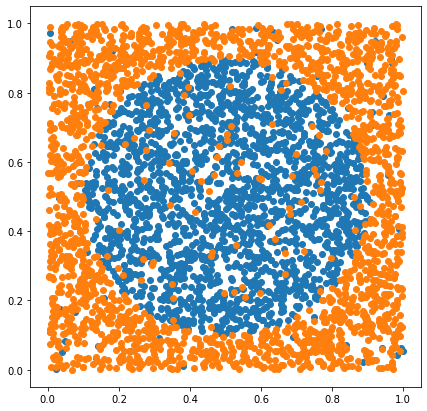

In [4]:
pos, neg = np.array([v[0] for v in values if v[1] == 1]), np.array([v[0] for v in values if v[1] == 0])
plt.figure(figsize=(7, 7))
plt.scatter(pos[:, 0], pos[:, 1])
plt.scatter(neg[:, 0], neg[:, 1])
plt.show()

In [5]:
smaller_cut = rich_cut[:1400]
print(smaller_cut[-1])

((2063, 423), 0.027747783635242936)


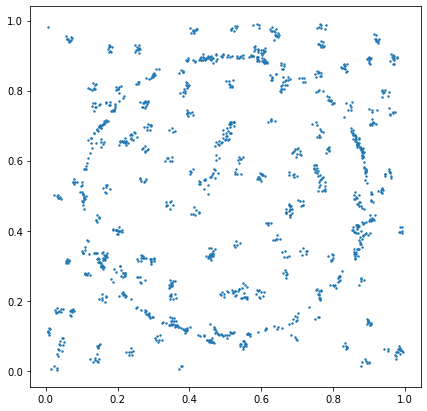

In [6]:
pts = np.array([(G.nodes[x[0]].value + G.nodes[x[1]].value) / 2 for x in [e[0] for e in smaller_cut]])
plt.figure(figsize=(7, 7))
plt.scatter(pts[:, 0], pts[:, 1], s=2)
plt.show()

In [7]:
a = range(360)
cx = [.5 + np.sin(np.pi * i/ 180) * .4 for i in a]
cy = [.5 + np.cos(np.pi * i/ 180) * .4 for i in a]

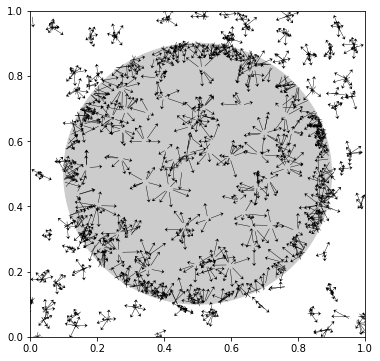

In [8]:
vecs = np.array([(G.nodes[x[0]].value - G.nodes[x[1]].value) * (G.nodes[x[0]]._class - G.nodes[x[1]]._class) for x in [e[0] for e in smaller_cut]])
plt.figure(figsize=(6, 6))
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.fill(cx, cy, color='#CCCCCC')
plt.quiver(pts[:, 0], pts[:, 1], vecs[:, 0], vecs[:, 1], width=.0013, scale=.5, headlength=7, headwidth=10, zorder=2)
plt.show()

In [19]:
def wilson(G, cut):
    cutset = set([r[0][0] for r in cut] + [r[0][1] for r in cut])
    local_cuts = dict((key, []) for key in cutset)
    for e in cut:
        local_cuts[e[0][0]].append(e)
        local_cuts[e[0][1]].append(e)

    clean_cut = set(cut)
    for k, lst in local_cuts.items():
        if len(lst) <= 4: # dim * 3 // 2
            continue
        for e in lst:
            if e in clean_cut: 
                clean_cut.remove(e)
    return list(clean_cut)

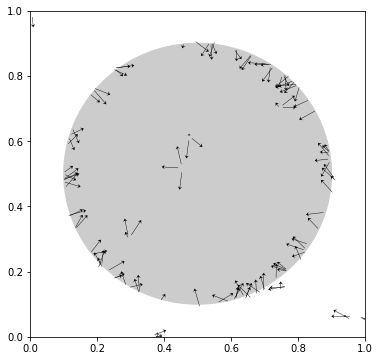

In [20]:
clean_cut = wilson(G, smaller_cut)
pts = np.array([(G.nodes[x[0]].value + G.nodes[x[1]].value) / 2 for x in [e[0] for e in clean_cut]])
vecs = np.array([(G.nodes[x[0]].value - G.nodes[x[1]].value) * (G.nodes[x[0]]._class - G.nodes[x[1]]._class) for x in [e[0] for e in clean_cut]])
plt.figure(figsize=(6, 6))
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.fill(cx, cy, color='#CCCCCC')
plt.quiver(pts[:, 0], pts[:, 1], vecs[:, 0], vecs[:, 1], width=.0013, scale=.5, headlength=7, headwidth=10, zorder=2)
plt.show()

get_grad_field_function: Edge index is prepared.


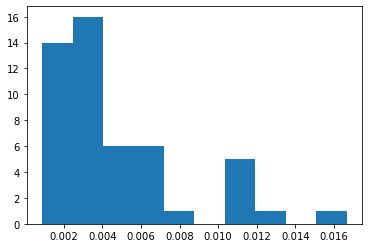

0.004673119320316656 0.00381970838588339
<class 'numpy.ndarray'>
field


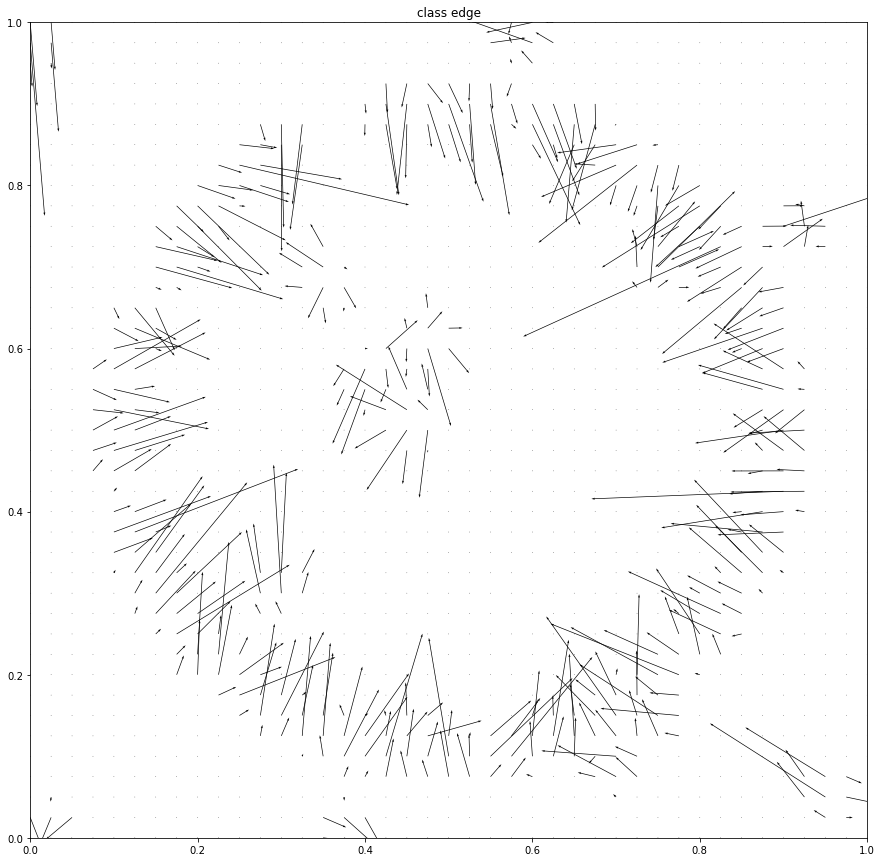

Computed in 9.0301s


In [11]:
import time
f = rbf.get_grad_field_function(G, clean_cut)

# avg_dist
dists = []
for i in range(50):
    n0 = random.choice(clean_cut)
    p0 = (G.nodes[n0[0][0]].value + G.nodes[n0[0][1]].value) / 2
    sd = []
    for n1 in clean_cut:
        if n0 == n1:
            continue
        p1 = (G.nodes[n1[0][0]].value + G.nodes[n1[0][1]].value) / 2
        d = vector_norm(p1 - p0)
        sd.append(d)
    dists.append(min(sd))

plt.hist(dists)
plt.show()
dists.sort()
print(sum(dists) / len(dists), dists[len(dists) // 2])
avg_shortest = sum(dists) / len(dists)
mid_shortest = dists[len(dists) // 2]
start = time.perf_counter()
plot_potential(0., 1., f, avg_shortest * 8, 41)
end = time.perf_counter()

print(f"Computed in {end - start:.4f}s")

In [12]:
support = []
for i in range(50):
    n = random.choice(G.nodes)
    support.append((n.value, n._class))

In [13]:
from nsw.cut_classifier import CutClassifier
cclf = CutClassifier(G, smaller_cut)
clf = cclf.classifier

Graph initialized with cut (1400).
Shape 2
Clean cut (123).
Shortest dist estimated (0.0075).
Support with 50 nodes is created.
Data dimensionality detected is 2. regularity = 6
	10.00% of graph construction
	20.00% of graph construction
	30.00% of graph construction
	40.00% of graph construction
	50.00% of graph construction
	60.00% of graph construction
	70.00% of graph construction
	80.00% of graph construction
	90.00% of graph construction
Support graph is built.
get_grad_field_function: Edge index is prepared.
Classifier function is ready.


<class 'float'>
flat


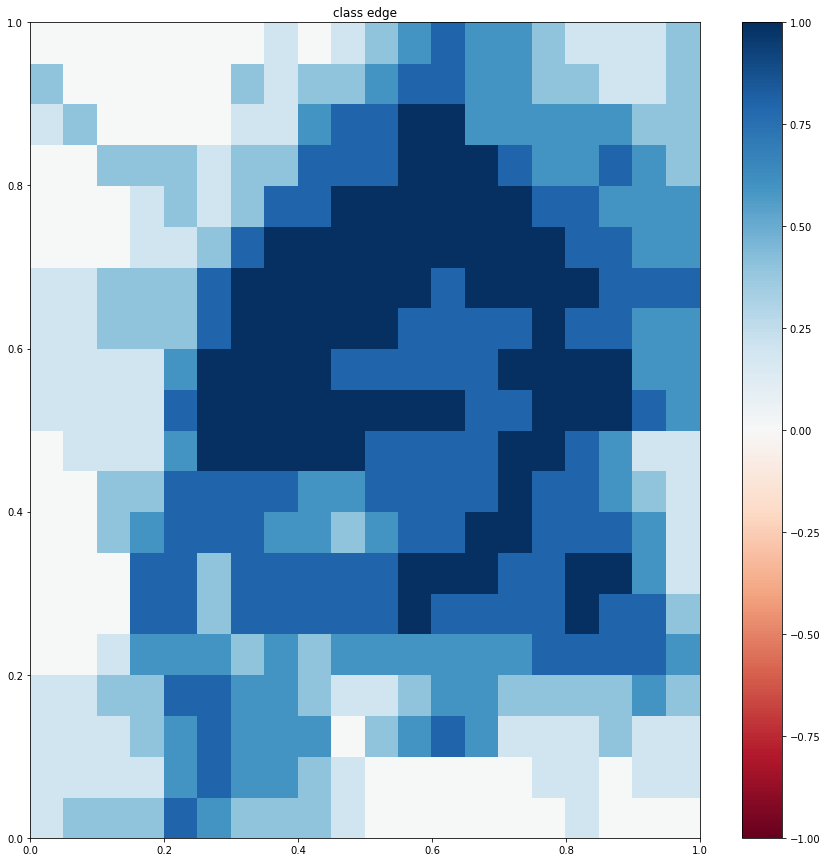

In [17]:
plot_potential(0., 1., clf, 8, 21)

In [18]:
N = 200
test = []
for i in range(N):
    p = np.array([random.random(), random.random()])
    cls = 1 if vector_norm(p - np.array([.5, .5])) < 0.4 else 0
    test.append((p, cls))
    
print("cutsize,small,R,k,m,acc")
for cutsize in [100, 500, 1000, 2000, 4000][::-1]:
    cclf = CutClassifier(G, rich_cut[:cutsize], verbose=False)
    clf = cclf.classifier
    for small in [0.0001, 0.005, 0.1]:
        for R in [16, 8, 4, 2, 1]:
            for k in [1, 5, 9, 13]:
                for m in [8, 16, 32]:
                    true = 0
                    for t in test:
                        pc = clf(t[0], R=R, small=small, closest=k, M=m)
                        if int(pc > .5) == t[1]: true += 1

                    print(f"{cutsize},{small},{R},{k},{m},{true / len(test):.3f}")

cutsize,small,R,k,m,acc
Graph initialized with cut (2738).
Shape 2
Clean cut (28).
Shortest dist estimated (0.0129).
Support with 50 nodes is created.
Support graph is built.
get_grad_field_function: Edge index is prepared.
Classifier function is ready.
4000,0.0001,16,1,8,0.720
4000,0.0001,16,1,16,0.730
4000,0.0001,16,1,32,0.730


KeyboardInterrupt: 